In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path 
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

Data Read

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = 'drive/My Drive'

In [ ]:
transactions = pd.read_csv(os.path.join(data_path, 'transactions.csv'), parse_dates=['date'],infer_datetime_format=True)
oil = pd.read_csv(os.path.join(data_path, 'oil.csv'), parse_dates=['date'], infer_datetime_format=True,index_col='date')
holidays = pd.read_csv(os.path.join(data_path, 'holidays_events.csv'), parse_dates=['date'], infer_datetime_format=True, dtype={'transferred': bool})
stores = pd.read_csv(os.path.join(data_path, 'stores.csv'), index_col='store_nbr')
df_train = pd.read_csv(os.path.join(data_path, 'train.csv'),dtype={'onpromotion': object},index_col='id',parse_dates=['date'], infer_datetime_format=True)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
stores.rename(columns={'type': 'store_type', 'cluster': 'store_cluster'}, inplace=True)
oil.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)
holidays.rename(columns={'type': 'holiday_type'}, inplace=True)

In [ ]:
oil = oil.loc[~oil.oil_price.isna()]
oil = oil.resample('1d').ffill().reset_index()

Data Preprocess

In [ ]:
def preprocess(df_train,holidays):
  df_train = pd.merge(df_train, stores, on='store_nbr', how='left')
  df_train = df_train.merge(transactions, how='left', on=['date', 'store_nbr'])
  df_train = pd.merge(df_train, oil, on='date', how='left')
  df_train['transactions'] = df_train['transactions'].fillna(0)
  df_train['oil_price'] = df_train['oil_price'].fillna(0)
  holidays = holidays.loc[holidays['transferred'] == False]

  holidays_nat = holidays[holidays['locale']=='National'].drop_duplicates(subset='date')
  holidays_reg = holidays[holidays['locale']=='Regional'].drop_duplicates(subset='date')
  holidays_loc = holidays[holidays['locale']=='Local'].drop_duplicates(subset='date')

  df_train = pd.merge(df_train, holidays_nat[['date','description']], on='date', how='left').rename(columns={'description': 'holiday_nat'})
  df_train = pd.merge(df_train, holidays_reg[['date', 'locale_name', 'description']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left').rename(columns={'description': 'holiday_reg'}).drop(columns=['locale_name'])
  df_train = pd.merge(df_train, holidays_loc[['date', 'locale_name', 'description']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left').rename(columns={'description': 'holiday_loc'}).drop(columns=['locale_name'])

  df_train[["holiday_nat", "holiday_reg", "holiday_loc"]] = df_train[["holiday_nat", "holiday_reg", "holiday_loc"]].fillna(0)
  df_train['holiday_reg'].loc[df_train['holiday_reg']!=0] = 1
  df_train['holiday_nat'].loc[df_train['holiday_nat']!=0] = 1
  df_train['holiday_loc'].loc[df_train['holiday_loc']!=0] = 1

  df_train['average_sales_by_family'] = df_train.groupby(["date", 'family'], observed=True).sales.transform('mean')
  df_train['average_sales_by_store'] = df_train.groupby(["date", 'store_nbr'], observed=True).sales.transform('mean')
  df_train['oil_price'] = df_train['oil_price'].interpolate().fillna(method='bfill')
  df_train['transactions'] = df_train['transactions'].interpolate().fillna(method='bfill')
  df_train['dayofweek'] = df_train['date'].dt.dayofweek.astype('str').astype('category')
  df_train['month'] = df_train['date'].dt.month.astype('str').astype('category')
  df_train['dayofyear'] = df_train['date'].dt.dayofyear.astype('str').astype('category')

  for cat_col in ['holiday_nat', 'holiday_reg', 'holiday_loc','city','state' , 'store_type', 'store_cluster', 'store_nbr', 'family']:
      df_train[cat_col] = df_train[cat_col].astype(str).astype('category')


  df_train['time_idx'] = (df_train['date'].dt.date - df_train['date'].dt.date.min()).dt.days
  return df_train

Long Term Dependency - sales that requires to look way back into past

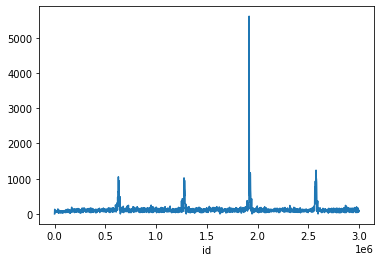

In [ ]:
df_train.loc[(df_train['family']=='FROZEN FOODS')&(df_train['store_nbr']==1)]['sales'].plot()

Short Term Dependency sales that require to only look back to immediate past

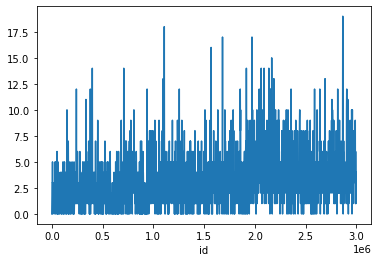

In [ ]:
df_train.loc[(df_train['family']=='AUTOMOTIVE')&(df_train['store_nbr']==1)]['sales'].plot()

Split Dataset

In [ ]:
long_seq = df_train.loc[(df_train['family']=='SCHOOL AND OFFICE SUPPLIES') | (df_train['family']=='FROZEN FOODS')]
short_seq = df_train.loc[~((df_train['family']=='SCHOOL AND OFFICE SUPPLIES') | (df_train['family']=='FROZEN FOODS'))]


In [ ]:
long_seq = preprocess(long_seq,holidays)
short_seq = preprocess(short_seq,holidays)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [ ]:
df_train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [ ]:
df_train['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

Short Seq


In [ ]:
pip install pytorch-forecasting

     |████████████████████████████████| 127 kB 4.3 MB/s 
     |████████████████████████████████| 582 kB 30.3 MB/s 
     |████████████████████████████████| 308 kB 56.9 MB/s 
     |████████████████████████████████| 81 kB 10.1 MB/s 
     |████████████████████████████████| 210 kB 66.0 MB/s 
     |████████████████████████████████| 596 kB 64.3 MB/s 
     |████████████████████████████████| 408 kB 48.2 MB/s 
     |████████████████████████████████| 136 kB 58.4 MB/s 
     |████████████████████████████████| 1.1 MB 58.2 MB/s 
     |████████████████████████████████| 271 kB 75.1 MB/s 
     |████████████████████████████████| 144 kB 72.9 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 78 kB 8.3 MB/s 
     |████████████████████████████████| 146 kB 51.8 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 113 kB 74.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11

Data Preparation and Data Loaders

In [ ]:
from pytorch_forecasting import TimeSeriesDataSet, Baseline, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer

In [ ]:
max_prediction_length = 15
max_encoder_length = 60 # Go back  60 Days 
training_cutoff = short_seq["time_idx"].max() - max_prediction_length

In [ ]:


training = TimeSeriesDataSet(
    short_seq[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=["store_nbr", "family"],
    min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["store_nbr", 
                         "family", 
                         "city", 
                         "state", 
                         "store_cluster", 
                         "store_type"],
    time_varying_known_categoricals=["holiday_nat", 
                                     "holiday_reg", 
                                     "holiday_loc", 
                                     "month", 
                                     "dayofweek",
                                     "dayofyear"],
    time_varying_known_reals=["time_idx", "onpromotion", 'oil_price'],
    time_varying_unknown_reals=[
        "sales",
        "transactions",
        "average_sales_by_family",
        "average_sales_by_store",
    ],
    target_normalizer=GroupNormalizer(
        groups=["store_nbr", "family"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)


validation = TimeSeriesDataSet.from_dataset(training, short_seq, predict=True, stop_randomization=True)


/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/encoders.py:724: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


In [ ]:

# create dataloaders for model
batch_size = 99  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2, drop_last=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size*18, num_workers=2,drop_last=True)

In [ ]:
short_seq['family'].nunique()*short_seq['store_nbr'].nunique()

1782

In [ ]:
next(iter(val_dataloader))


({'decoder_cat': tensor([[[  0,   0,  18,  ...,  10,   1, 127],
           [  0,   0,  18,  ...,  10,   2, 128],
           [  0,   0,  18,  ...,  10,   3, 129],
           ...,
           [  0,   0,  18,  ...,  10,   6, 140],
           [  0,   0,  18,  ...,  10,   0, 141],
           [  0,   0,  18,  ...,  10,   1, 142]],
  
          [[  0,   1,  18,  ...,  10,   1, 127],
           [  0,   1,  18,  ...,  10,   2, 128],
           [  0,   1,  18,  ...,  10,   3, 129],
           ...,
           [  0,   1,  18,  ...,  10,   6, 140],
           [  0,   1,  18,  ...,  10,   0, 141],
           [  0,   1,  18,  ...,  10,   1, 142]],
  
          [[  0,   2,  18,  ...,  10,   1, 127],
           [  0,   2,  18,  ...,  10,   2, 128],
           [  0,   2,  18,  ...,  10,   3, 129],
           ...,
           [  0,   2,  18,  ...,  10,   6, 140],
           [  0,   2,  18,  ...,  10,   0, 141],
           [  0,   2,  18,  ...,  10,   1, 142]],
  
          ...,
  
          [[ 53,  30,  18

In [ ]:
import torch

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


114.18152618408203

HyperParameter Optmization

In [ ]:
import pytorch_lightning as pl
from pytorch_forecasting.metrics import RMSE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import pickle

In [ ]:

study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 64),
    hidden_continuous_size_range=(8, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30, log_every_n_steps=15, gpus=1),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False, 
    timeout=4200
)



# show best hyperparameters
print(study.best_trial.params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[I 2022-05-01 19:14:02,770] A new study created in memory with name: no-name-2e4d9aad-aee8-4a7e-a901-5696a2fafaaa
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:172: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is alr

{'gradient_clip_val': 0.8828179401587463, 'hidden_size': 14, 'dropout': 0.2161577923959459, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.04481395108044063}


In [ ]:
#Saving the parameters
MIN_DELTA  = 1e-4
PATIENCE = 10


MAX_EPOCHS = 150
GPUS = 1
GRADIENT_CLIP_VAL=study.best_trial.params['gradient_clip_val']
LIMIT_TRAIN_BATCHES=30


LR = study.best_trial.params['learning_rate']
HIDDEN_SIZE = study.best_trial.params['hidden_size']
DROPOUT = study.best_trial.params['dropout']
ATTENTION_HEAD_SIZE = study.best_trial.params['attention_head_size']
HIDDEN_CONTINUOUS_SIZE = study.best_trial.params['hidden_continuous_size']
OUTPUT_SIZE=7
REDUCE_ON_PLATEAU_PATIENCE=5


In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.metrics import QuantileLoss
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=MIN_DELTA, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gpus=GPUS,
    weights_summary="top",
    gradient_clip_val=GRADIENT_CLIP_VAL,
    limit_train_batches=LIMIT_TRAIN_BATCHES,#oment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    log_every_n_steps=10
    
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LR,
    hidden_size=HIDDEN_SIZE,
    attention_head_size=ATTENTION_HEAD_SIZE,
    dropout=DROPOUT,
    hidden_continuous_size=HIDDEN_CONTINUOUS_SIZE,
    output_size=OUTPUT_SIZE,# 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=REDUCE_ON_PLATEAU_PATIENCE,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 30.2k


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [ ]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 6.8 K 
3  | prescalers                         | ModuleDict                      | 176   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 6.3 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 868   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 868   
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Saving the best model

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


Prediction and Visualisation

In [ ]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [ ]:
raw_predictions['prediction'].shape

torch.Size([1674, 15, 7])

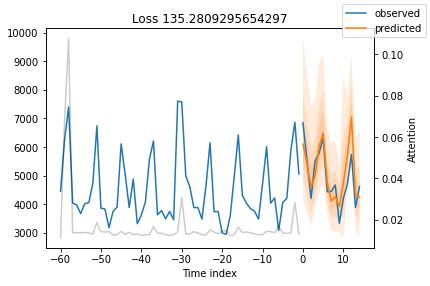

In [ ]:
best_tft.plot_prediction(x, raw_predictions, idx=755, add_loss_to_title=True);

Save the results

In [ ]:
for i in range(1782):
  store = x['groups'][i].tolist()[0]
  family = x['groups'][i].tolist()[1]
  
  for j in range(15):
    real = x['decoder_target'][i].tolist()[j]
    time = x['decoder_time_idx'][i].tolist()[j]
    pred = raw_predictions['prediction'][i,:,3].tolist()[j]
    short_pred = short_pred.append({'time': time, 'store':store,'family':family,'real':real,'pred':pred}, ignore_index=True)


In [ ]:
short_pred.to_csv('Short_Freq_Pred_1.csv',index=False)

In [ ]:
short_seq['family'].unique()[11]

'FROZEN FOODS'

In [ ]:
short_seq['store_nbr'].unique()[0]

'1'

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:1666: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(**kwargs)


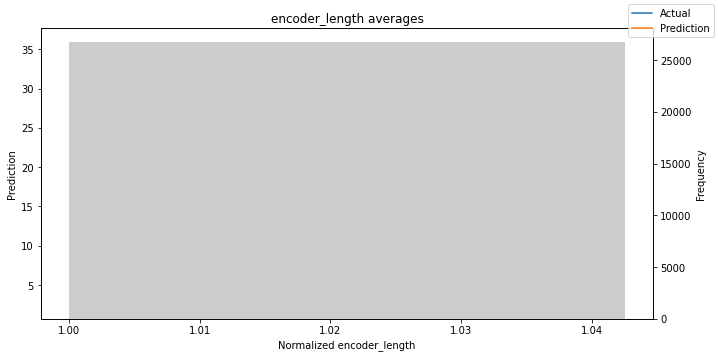

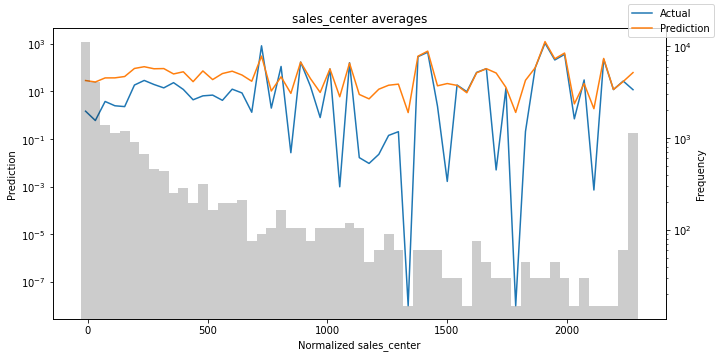

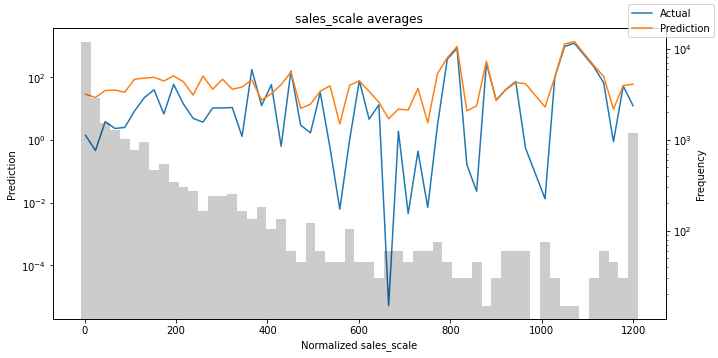

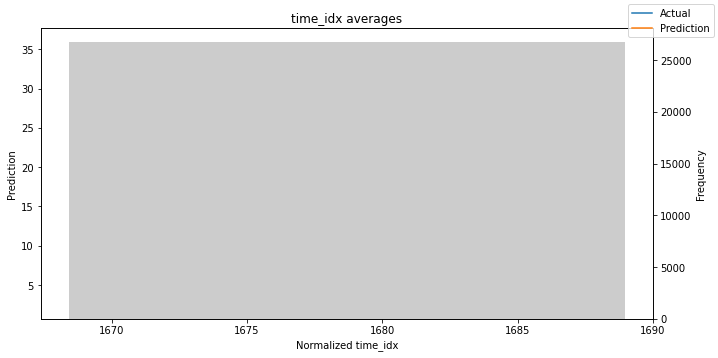

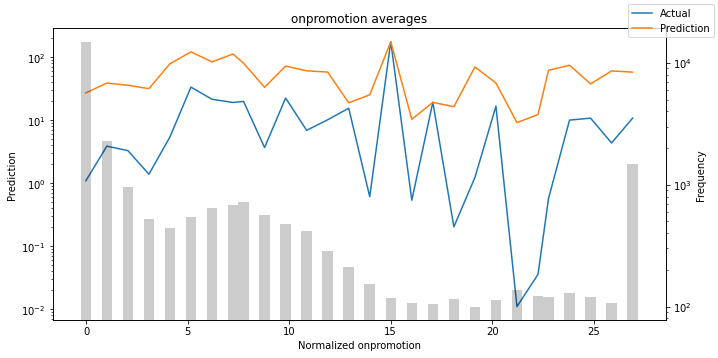

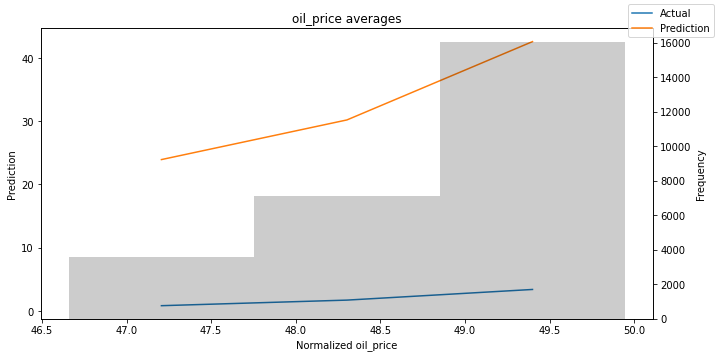

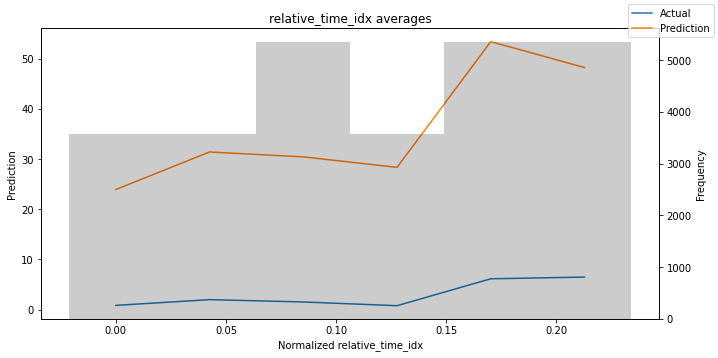

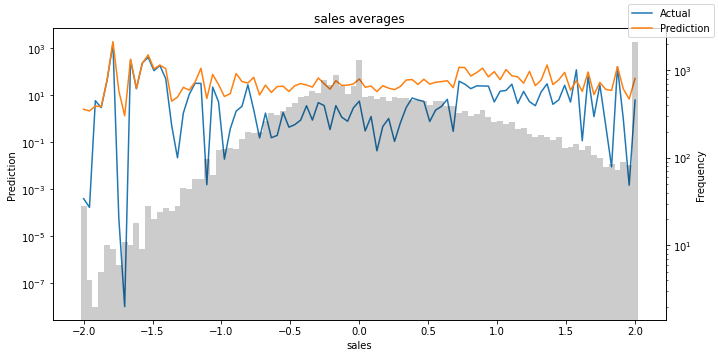

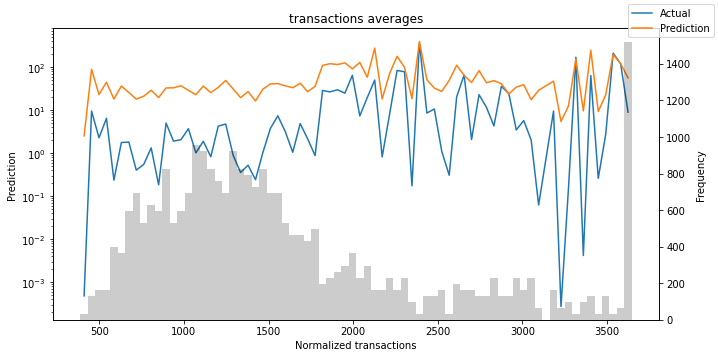

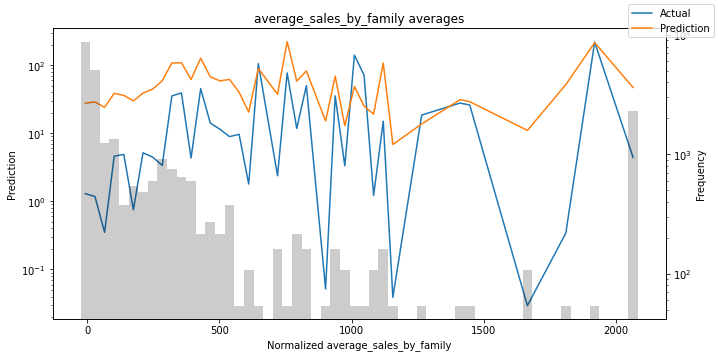

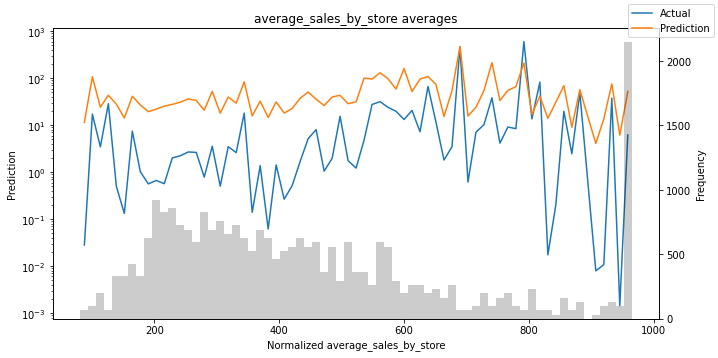

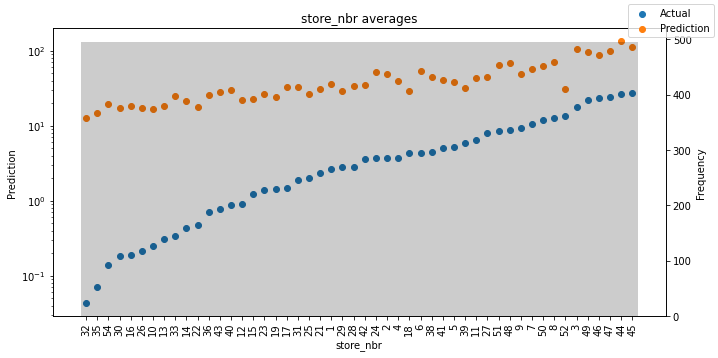

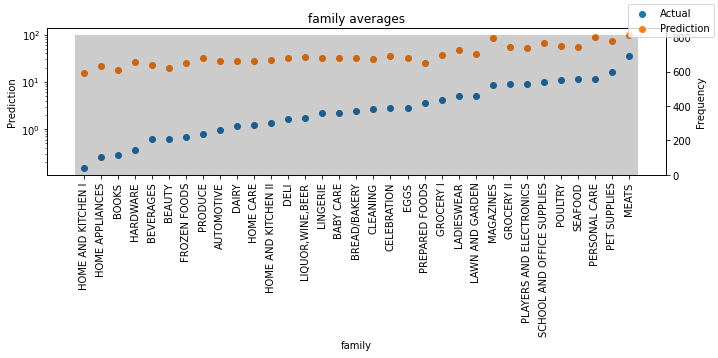

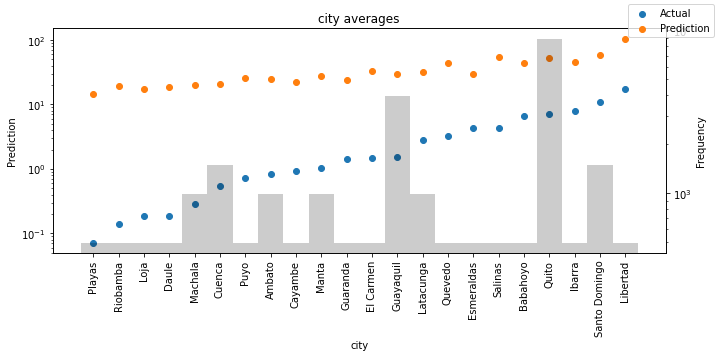

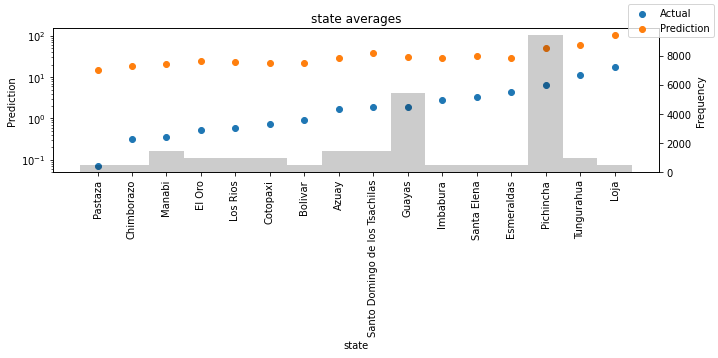

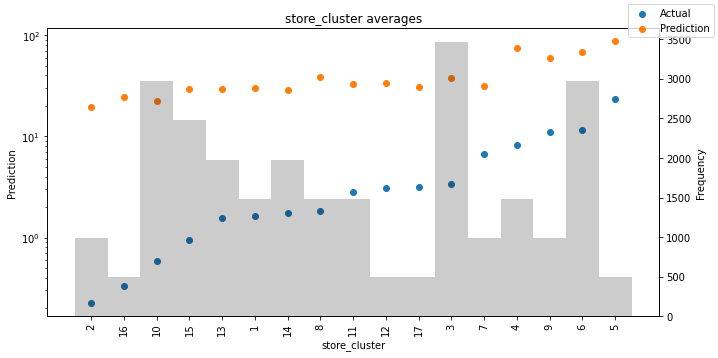

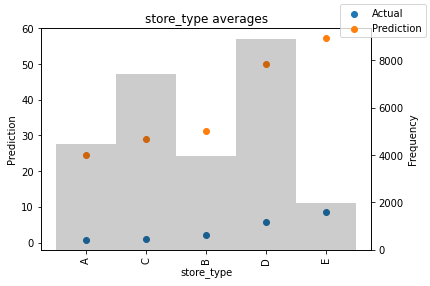

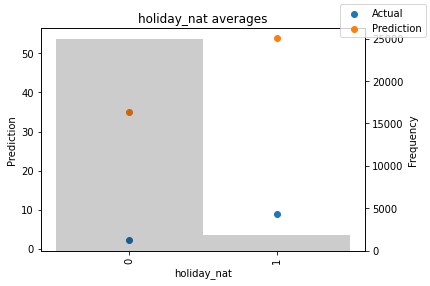

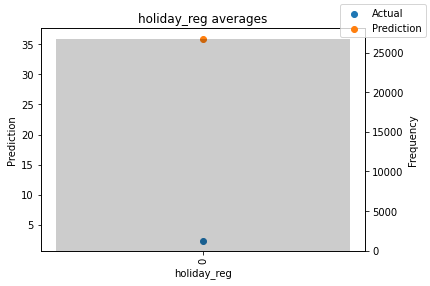

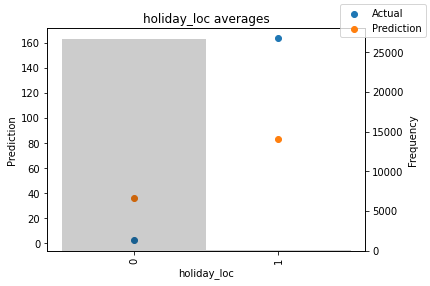

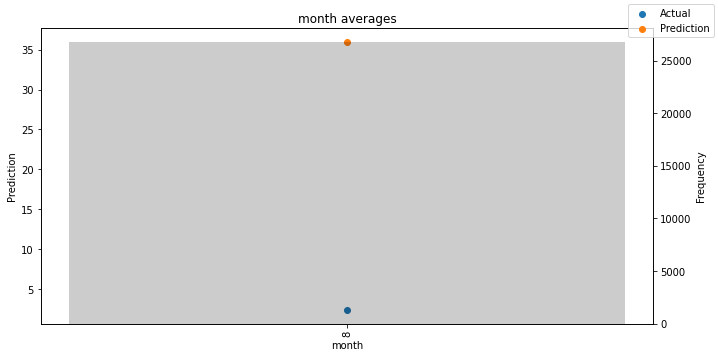

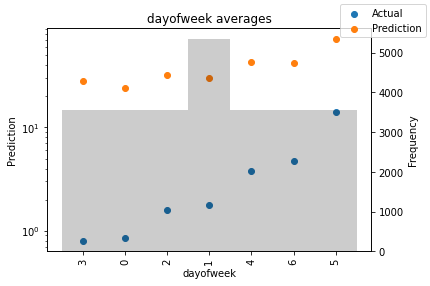

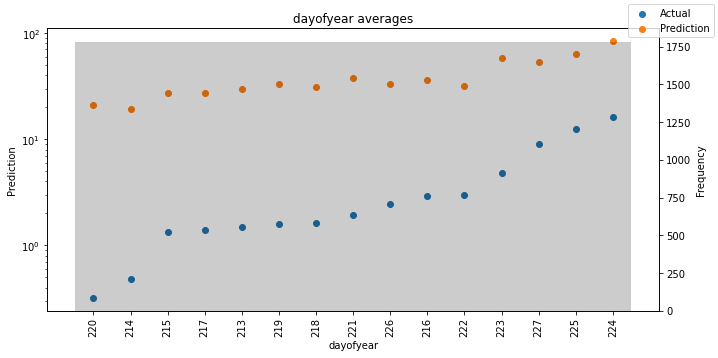

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [ ]:
encoder_data = df_train[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]


last_data = df_train[df_train['time_idx'].isin([idx  -  prediction_steps for idx in df_test['time_idx'].unique()])]
last_data['time_idx'] = last_data['time_idx'] + prediction_steps
decoder_data = pd.merge(df_test[[col for col in df_test.columns if 'sales' not in col]], 
        last_data[['time_idx','store_nbr', 'family', 'sales', 'average_sales_by_family', 'average_sales_by_store' , 'transactions']],
        on = ['time_idx', 'store_nbr', 'family',]
        )

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

{'attention': <Figure size 432x288 with 1 Axes>,
 'decoder_variables': <Figure size 504x324 with 1 Axes>,
 'encoder_variables': <Figure size 504x396 with 1 Axes>,
 'static_variables': <Figure size 504x306 with 1 Axes>}

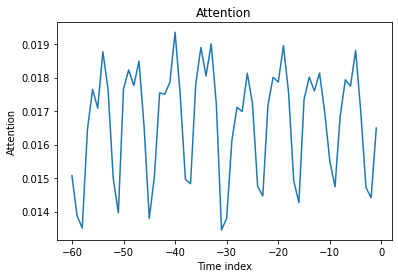

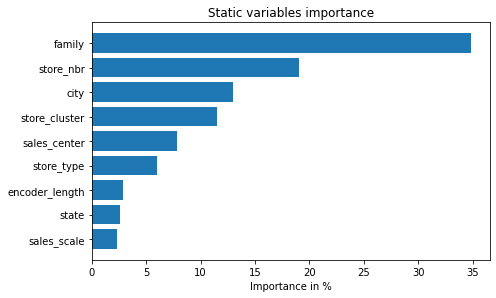

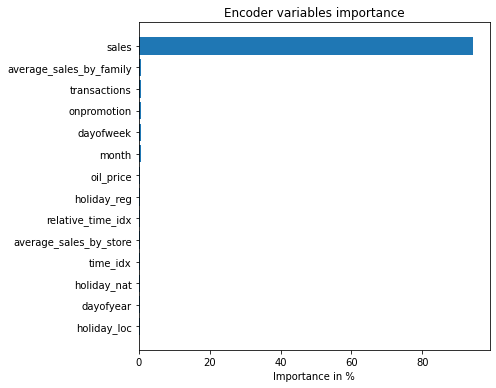

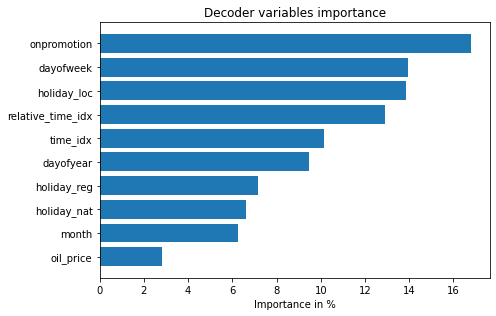

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

Long Seq

In [ ]:
!git clone https://github.com/zhouhaoyi/Informer2020.git

Cloning into 'Informer2020'...
remote: Enumerating objects: 573, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 573 (delta 184), reused 176 (delta 176), pack-reused 366
Receiving objects: 100% (573/573), 6.48 MiB | 9.71 MiB/s, done.
Resolving deltas: 100% (331/331), done.


In [ ]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [ ]:
!pip install -r ./Informer2020/requirements.txt

     |████████████████████████████████| 13.1 MB 3.8 MB/s 
     |████████████████████████████████| 14.5 MB 52.3 MB/s 
     |████████████████████████████████| 10.4 MB 24.5 MB/s 
     |████████████████████████████████| 6.7 MB 24.1 MB/s 
     |████████████████████████████████| 735.5 MB 14 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing instal

In [ ]:
long_seq

,date,store_nbr,family,sales,onpromotion,city,state,store_type,store_cluster,transactions,oil_price,holiday_nat,holiday_reg,holiday_loc,average_sales_by_family,average_sales_by_store,dayofweek,month,dayofyear,time_idx
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,0.0,0.00,1,0,0,0.0,0.000000,1,1,1,0
37,2013-01-01,10,BOOKS,0.0,0,Quito,Pichincha,C,15,0.0,0.00,1,0,0,0.0,0.000000,1,1,1,0
70,2013-01-01,11,BOOKS,0.0,0,Cayambe,Pichincha,B,6,0.0,0.00,1,0,0,0.0,0.000000,1,1,1,0
103,2013-01-01,12,BOOKS,0.0,0,Latacunga,Cotopaxi,C,15,0.0,0.00,1,0,0,0.0,0.000000,1,1,1,0
136,2013-01-01,13,BOOKS,0.0,0,Latacunga,Cotopaxi,C,15,0.0,0.00,1,0,0,0.0,0.000000,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000727,2017-08-15,54,BOOKS,0.0,0,El Carmen,Manabi,C,3,802.0,47.57,0,0,0,0.0,383.844182,1,8,227,1687
3000760,2017-08-15,6,BOOKS,0.0,0,Quito,Pichincha,D,13,1589.0,47.57,0,0,0,0.0,419.673000,1,8,227,1687
3000793,2017-08-15,7,BOOKS,0.0,0,Quito,Pichincha,D,8,1780.0,47.57,0,0,0,0.0,568.008969,1,8,227,1687
3000826,2017-08-15,8,BOOKS,0.0,0,Quito,Pichincha,D,8,2621.0,47.57,0,0,0,0.0,537.087152,1,8,227,1687


In [ ]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os
from utils.tools import dotdict
import torch
from exp.exp_informer import Exp_Informer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
long_pred=pd.DataFrame()

Training and predicting for each combination

In [ ]:
for i in long_seq['family'].unique():
  for j in long_seq['store_nbr'].unique():
    #get data
    d = long_seq.loc[(long_seq['family']==i) & (long_seq['store_nbr']==j)]
    d=d[['date','sales','transactions', 'oil_price','average_sales_by_family','average_sales_by_store','dayofweek', 'month', 'dayofyear']]
    d.to_csv('trial.csv',index=False)
    #set model parameters
    args = dotdict()
    args.model = 'informer' 
    args.target = 'sales'
    args.freq = 'd'
    args.data = 'custom' # data
    args.root_path = '/content'
    args.data_path = 'trial.csv' # data file
    args.features = 'MS' 
    args.checkpoints = './informer_checkpoints' # location of model checkpoints
    args.seq_len = 150 # input sequence length of Informer encoder
    args.label_len = 150 # start token length of Informer decoder
    args.pred_len = 15 # prediction sequence length
    # Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

    args.enc_in = 8 # encoder input size
    args.dec_in = 8# decoder input size
    args.c_out = 1 # output size
    args.factor = 8 # probsparse attn factor
    args.d_model = 1024 # dimension of model
    args.n_heads = 2 # num of heads
    args.e_layers = 3 # num of encoder layers
    args.d_layers = 1 # num of decoder layers
    args.d_ff = 2048 # dimension of fcn in model
    args.dropout = 0.05 # dropout
    args.attn = 'prob' # attention used in encoder, options:[prob, full]
    args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
    args.activation = 'gelu' # activation
    args.distil = True # whether to use distilling in encoder
    args.output_attention = True # whether to output attention in ecoder
    args.mix = True
    args.padding = 0
    # args.freq = 'h'
    args.scale = True
    args.batch_size = 32
    args.learning_rate = 0.00001
    args.loss = 'mse'
    args.lradj = 'type1'
    args.use_amp = False # whether to use automatic mixed precision training
    args.inverse=True
    args.num_workers = 0
    args.itr = 1
    args.train_epochs = 20
    args.patience = 3
    args.des = 'exp'
    args.detail_freq = 'd'
    args.use_gpu = True if torch.cuda.is_available() else False
    args.gpu = 0

    args.use_multi_gpu = False
    args.devices = '0,1,2,3'
    args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

    if args.use_gpu and args.use_multi_gpu:
        args.devices = args.devices.replace(' ','')
        device_ids = args.devices.split(',')
        args.device_ids = [int(id_) for id_ in device_ids]
        args.gpu = args.device_ids[0]
    Exp = Exp_Informer

    #Train the model, hyparameters are adjusted accordingly
    for ii in range(args.itr):
        # setting record of experiments
        setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                    args.seq_len, args.label_len, args.pred_len,
                    args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

        # set experiments
        exp = Exp(args)
        
        # train
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        exp.train(setting)
        
        # test
        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting)

        torch.cuda.empty_cache()
    #prediction
    exp.predict(setting, True)
    prediction = np.load('./results/'+setting+'/real_prediction.npy')  
    for p in range(15):
      if p!=14:
        long_pred = long_pred.append({'time':d['date'][-15+p:-14+p].values[0],'store':j,'family':i,'real':d['sales'][-15+p:-14+p].values[0],'pred':prediction[0,:,-1][p]}, ignore_index=True)
      else: 
        long_pred = long_pred.append({'time':d['date'][-1:].values[0],'store':j,'family':i,'real':d['sales'][-1:].values[0],'pred':prediction[0,:,-1][p]}, ignore_index=True)
    

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl150_ll150_pl15_dm1024_nh2_el3_dl1_df2048_atprob_fc8_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1014
val 156
test 322
Epoch: 1 cost time: 7.736307144165039
Epoch: 1, Steps: 31 | Train Loss: 43597.4206464 Vali Loss: 3387.0661621 Test Loss: 17925.5019531
Validation loss decreased (inf --> 3387.066162).  Saving model ...
Updating learning rate to 1e-05
Epoch: 2 cost time: 7.549347639083862
Epoch: 2, Steps: 31 | Train Loss: 37778.8773627 Vali Loss: 3255.7890625 Test Loss: 20673.3320312
Validation loss decreased (3387.066162 --> 3255.789062).  Saving model ...
Updating learning rate to 5e-06
Epoch: 3 cost time: 7.918030500411987
Epoch: 3, Steps: 31 | Train Loss: 37766.3315745 Vali Loss: 3873.2021484 Test Loss: 25256.0839844
EarlyStopping counter: 1 out of 3
Updating learning rate to 2.5e-06
Epoch: 4 cost time: 7.535790681838989
Epoch: 4, Steps: 31 | Train Loss: 36366.0934429 Vali Loss: 3550.0029297 Test Loss: 218

In [ ]:
long_pred.to_csv('long_pred.csv',index=False)

In [ ]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1
# args.root_path = './content'
freq = 'd'
# args.root_path = './content'
# args.data_path = 'trial.csv'
data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
import numpy as np
exp.predict(setting, True)
prediction = np.load('./results/'+setting+'/real_prediction.npy')
true = np.load('./results/'+setting+'/true.npy')
pred = np.load('./results/'+setting+'/pred.npy')
prediction.shape

pred 1


(1, 15, 1)

In [ ]:
prediction

array([[[0.2885679 ],
        [0.5871469 ],
        [0.57054687],
        [0.543981  ],
        [0.5242991 ],
        [0.45782122],
        [0.52274185],
        [0.72396445],
        [0.8178372 ],
        [0.7741037 ],
        [0.82580686],
        [0.72936237],
        [0.7717233 ],
        [0.7959447 ],
        [0.78930455]]], dtype=float32)

In [ ]:
# attention visualization
model = exp.model
idx = 0
for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
    if i!=idx:
        continue
    batch_x = batch_x.float().to(exp.device)
    batch_y = batch_y.float()

    batch_x_mark = batch_x_mark.float().to(exp.device)
    batch_y_mark = batch_y_mark.float().to(exp.device)
    
    dec_inp = torch.zeros_like(batch_y[:,-args.pred_len:,:]).float()
    dec_inp = torch.cat([batch_y[:,:args.label_len,:], dec_inp], dim=1).float().to(exp.device)
    
    outputs,attn = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

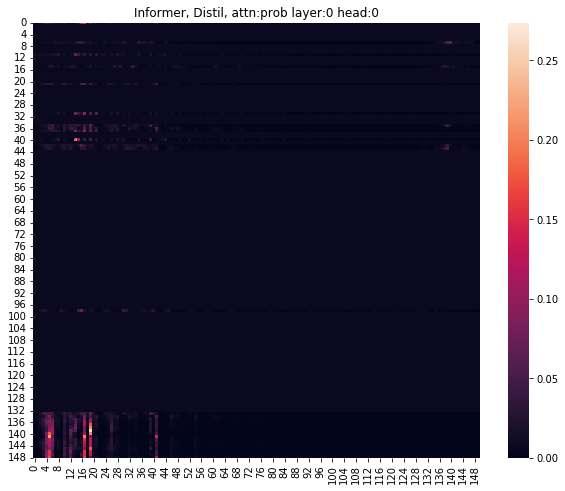

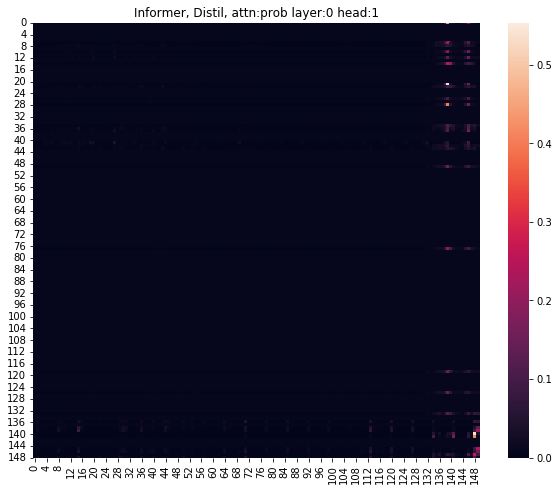

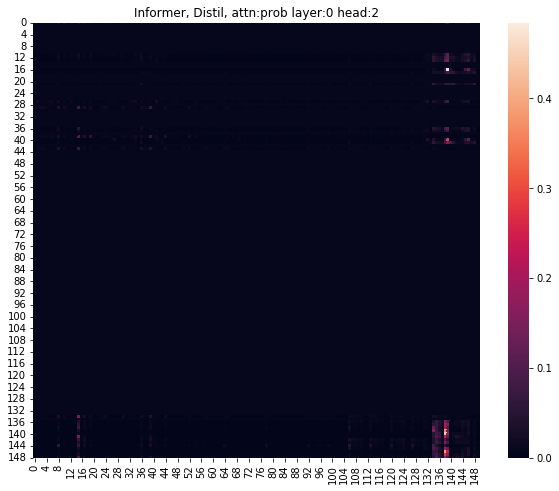

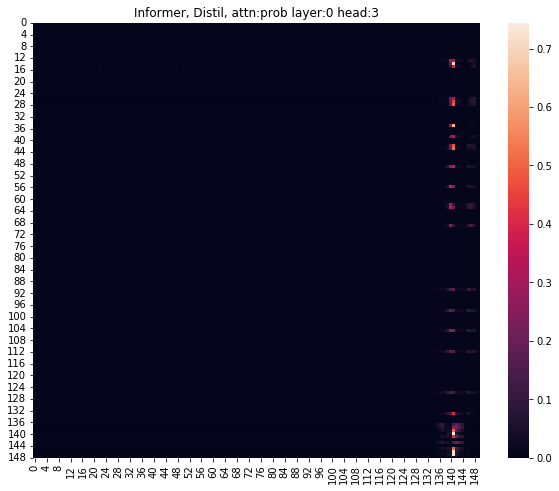

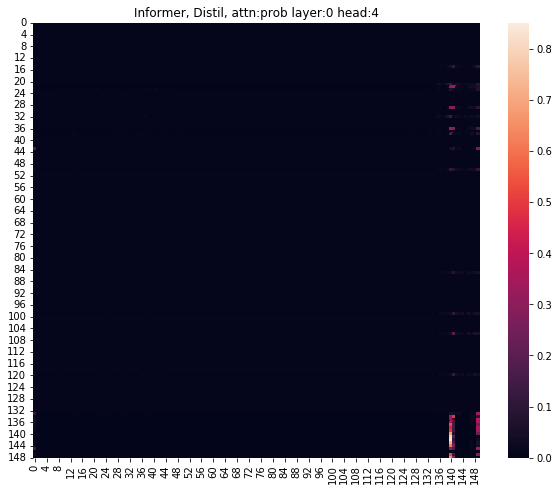

In [ ]:
layer = 0
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,5):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

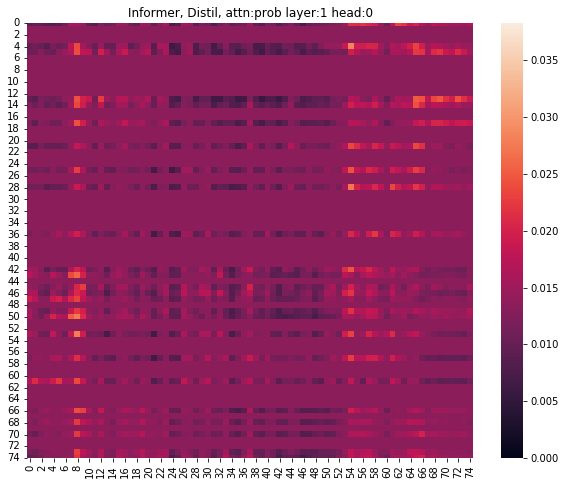

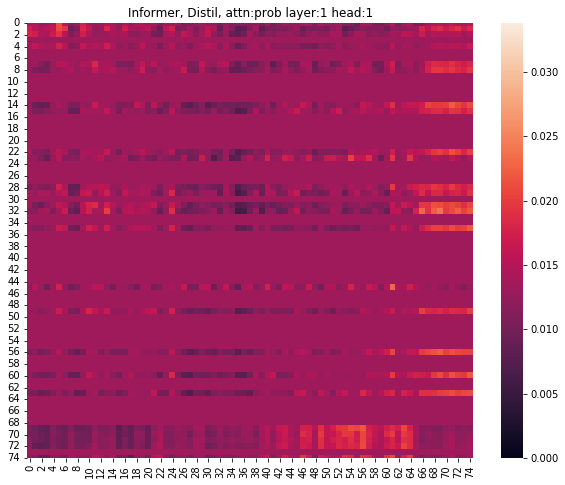

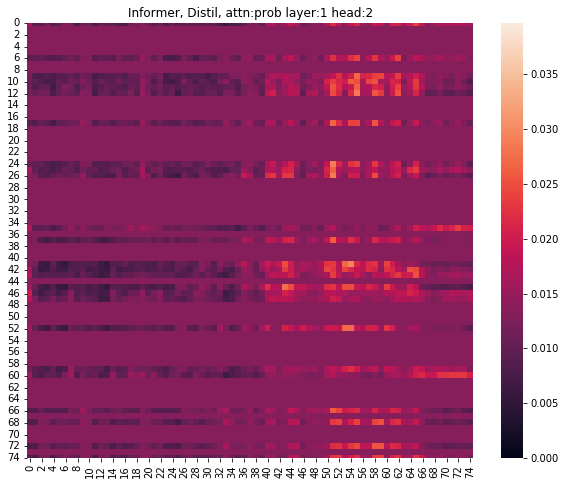

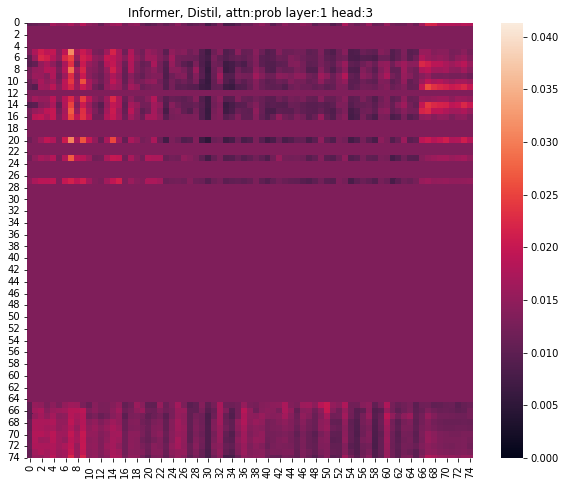

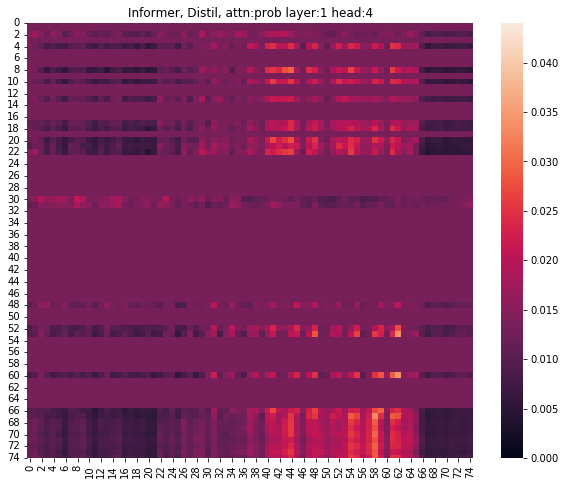

In [ ]:
layer = 1
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,5):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

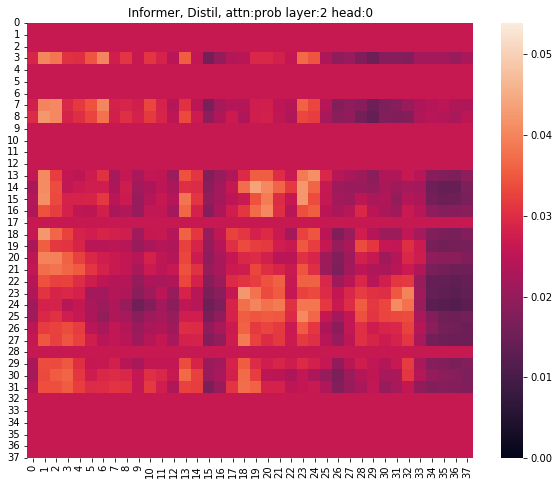

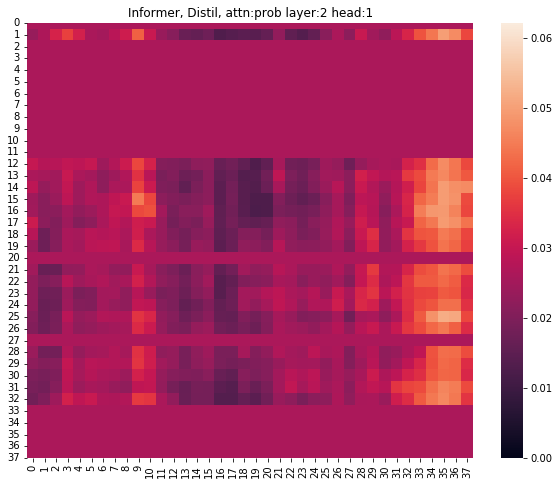

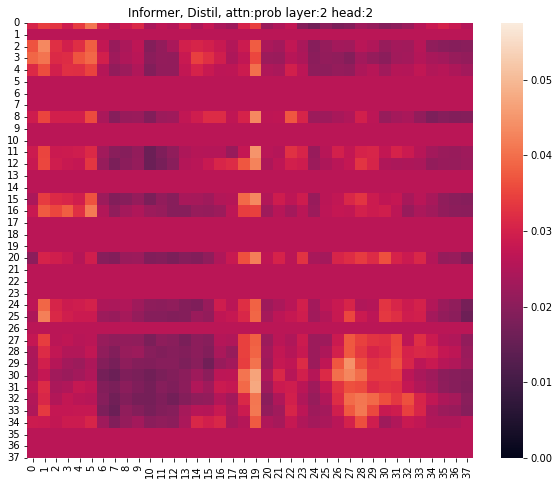

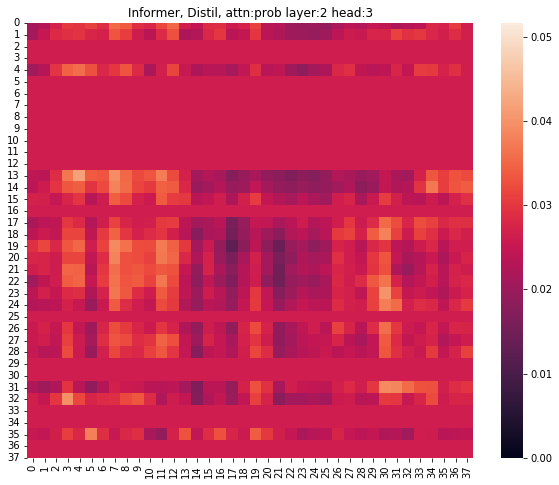

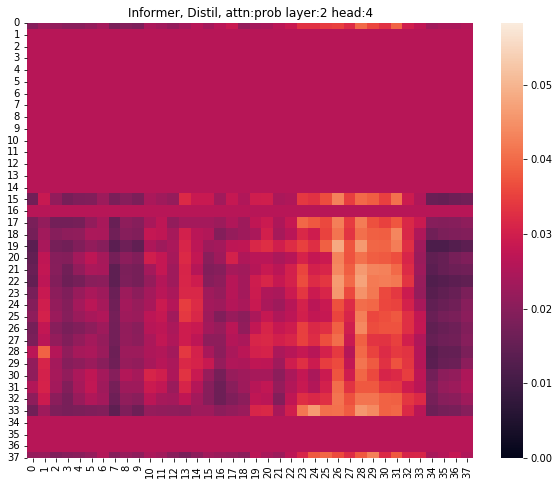

In [ ]:
layer = 2
distil = 'Distil' if args.distil else 'NoDistil'
for h in range(0,5):
    plt.figure(figsize=[10,8])
    plt.title('Informer, {}, attn:{} layer:{} head:{}'.format(distil, args.attn, layer, h))
    A = attn[layer][0,h].detach().cpu().numpy()
    ax = sns.heatmap(A, vmin=0, vmax=A.max()+0.01)
    plt.show()

Results

In [ ]:
d1 = pd.read_csv('/content/long_pred (1).csv')
d1

,time,store,family,real,pred
0,2017-08-01,1.0,FROZEN FOODS,144.126,124.160416
1,2017-08-02,1.0,FROZEN FOODS,200.899,110.365240
2,2017-08-03,1.0,FROZEN FOODS,132.185,141.925480
3,2017-08-04,1.0,FROZEN FOODS,143.000,120.879074
4,2017-08-05,1.0,FROZEN FOODS,155.597,103.980190
...,...,...,...,...,...
1615,2017-08-11,9.0,SCHOOL AND OFFICE SUPPLIES,140.000,15.086756
1616,2017-08-12,9.0,SCHOOL AND OFFICE SUPPLIES,138.000,15.056932
1617,2017-08-13,9.0,SCHOOL AND OFFICE SUPPLIES,200.000,14.963507
1618,2017-08-14,9.0,SCHOOL AND OFFICE SUPPLIES,182.000,14.925928


In [ ]:
d2 = pd.read_csv('/content/Short_Freq_Pred_1.csv')
df3 = d1[['real','pred']].append(d2[['real','pred']], ignore_index=True)
df3

,real,pred
0,144.126000,124.160416
1,200.899000,110.365240
2,132.185000,141.925480
3,143.000000,120.879074
4,155.597000,103.980190
...,...,...
26725,23.830999,11.924411
26726,16.859001,27.016300
26727,20.000000,21.104015
26728,17.000000,12.412012


In [ ]:
d4 = pd.read_csv('/content/Short_Freq_Pred_2.csv')

In [ ]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
results = pd.DataFrame()

In [ ]:
results = results.append({'instance_model':'TFT',
                          'rmse':rmse(d4['real'], d4['pred']),
                          'rmsle':np.sqrt(mean_squared_log_error(d4['real'], d4['pred'])),
                          'mae':mae(d4['real'], d4['pred']),
                          'mse':mean_squared_error(d4['real'], d4['pred'])},
                         ignore_index=True)
results

,instance_model,mae,mse,rmse,rmsle
0,TFT,87.466494,93076.022517,305.083632,0.591563


In [ ]:
results = results.append({'instance_model':'TFT + Informer',
                          'rmse':rmse(df3['real'], df3['pred']),
                          'rmsle':np.sqrt(mean_squared_log_error(df3['real'], df3['pred'])),
                          'mae':mae(df3['real'], df3['pred']),
                          'mse':mean_squared_error(df3['real'], df3['pred'])},
                         ignore_index=True)
results

,instance_model,mae,mse,rmse,rmsle
0,TFT,87.466494,93076.022517,305.083632,0.591563
1,TFT + Informer,83.945107,89838.131219,299.730097,0.603606
